# Implementing GRADCAM & Cutout

### The same network in 25 epochs improved accuracy from 74.78% (Cell No. 7) TO 75.14%

### Import the required modules and set seed for numpy operations

In [2]:
from google.colab import drive
drive.mount('/content/my-drive')

from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.datasets import cifar10
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import time

% matplotlib inline
np.random.seed(2017) 

Drive already mounted at /content/my-drive; to attempt to forcibly remount, call drive.mount("/content/my-drive", force_remount=True).


Using TensorFlow backend.


In [3]:
!ls /content/my-drive/'My Drive'/eva_stored_from_colab/

drive_location	eva_9gradcam_model.hdf5  tonystark.png


### Examine Input Data

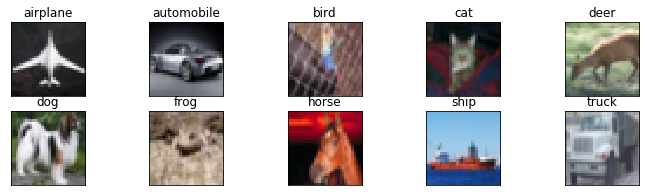

In [4]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(12,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Defining required functions:
- plotting model history
- calculating accuracy
- learning rate scheduler

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

### Convert labels to categorical & train data to float from int

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Check Accuracy

In [7]:
checkpointfilepath = "/content/my-drive/My Drive/eva_stored_from_colab/eva_9gradcam_model.hdf5"
model = load_model(checkpointfilepath)

#model.load_weights(checkpointfilepath)

loss, acc = model.evaluate(test_features, test_labels, verbose=0)

#score = model.evaluate(X_test, Y_test, verbose=0)
print(loss, acc)

W0818 16:14:14.016989 140685878994816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 16:14:14.067791 140685878994816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 16:14:14.115871 140685878994816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 16:14:14.117082 140685878994816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 16:14:14.118869 140685878

0.7900001672744751 0.7478


# GRADCAM Implementation

## Import required modules

In [0]:
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io

## Create & Plot Random GradCam images

In [17]:
(agn_train_features, agn_train_labels), (agn_test_features, agn_test_labels) = cifar10.load_data()

heatmap_array = []


random_img_num_array = []


for i in range(num_classes):

    # CHOOSE RANDOM IMAGE FOR THIS CLASS
    idx = np.where(agn_train_labels[:]==i)[0]
    features_idx = agn_train_features[idx,:,:,:]
    random_img_num_array.append(np.random.randint(features_idx.shape[0]))

random_img_num_array = np.array(random_img_num_array)

    

for img_num in random_img_num_array:
    
    print(img_num)
    
    selected_image = train_features[img_num]
    
    #GET THE PREDICTION & SELECT LAST LAYER OUTPUT FOR THIS CLASS
    pred = model.predict(np.expand_dims(selected_image, axis=0))
    class_output = model.output[:, np.argmax(pred)]
    last_conv_layer = model.get_layer(model.layers[-6].name)
    
    
    #CALCULATE GRADS OUTPUT vs LAST LAYER & "GENERAL AVERAGE POOL" THEM IN EACH CHANNEL
    selected_image = np.expand_dims(selected_image, axis=0)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([selected_image])
    for i in range(10):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    #CREATE HEATMAP
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = np.reshape(selected_image, selected_image.shape[1:])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    heatmap_array.append([img, superimposed_img])

4161
696
2801
4078
4918
4063
4687
169
599
896


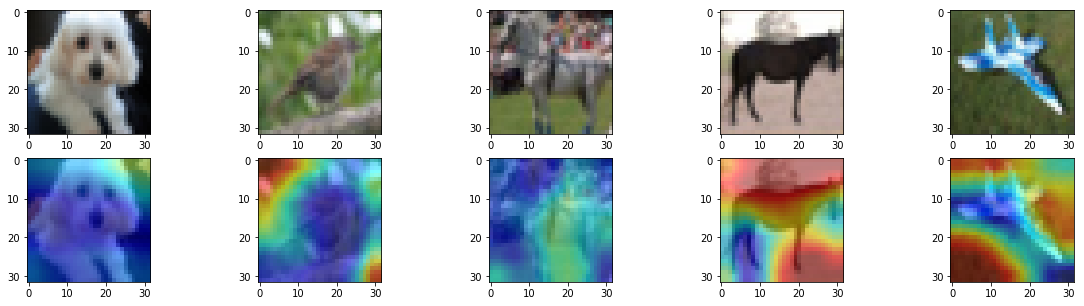

In [18]:
#PLOT HEATMAPS:

heatmap_array_final = heatmap_array[:5]

row_size = 2
col_size = 5

fig, ax = plt.subplots(row_size, col_size, figsize = (20, 5))

col_num = 0

for img, superimposed_img in heatmap_array_final:
    
    ax[0][col_num].imshow(img)
    ax[1][col_num].imshow(superimposed_img)
    
    col_num += 1
    

# CUTOUT Implementation

## Copying Eraser Code from the given github link

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Network

In [19]:
#CORRECTED NETWORK
model = Sequential()

#Convolution Block 1
model.add(Convolution2D(64, 3, 3, input_shape=(32,32,3)))     #Receptive Field:  3;   Input Channels:  3;  Resol:  30
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

model.add(Convolution2D(128, 3))                           #Receptive Field:  5;   Input Channels:  32;  Resol:  28
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

model.add(Convolution2D(256, 3))                           #Receptive Field:  7;   Input Channels: 64;  Resol:  26
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

#Transition Block 1
model.add(Convolution2D(256, 1, activation='relu'))                           #Receptive Field:  7;   Input Channels: 128;  Resol:  26
model.add(MaxPooling2D(2,2))                                                    #Receptive Field: 14;   Input Channels: 128;  Resol:  13

#Convolution Block 2
model.add(Convolution2D(64, 3))                            #Receptive Field: 16;   Input Channels: 128;  Resol:  11
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

model.add(Convolution2D(128, 3))                           #Receptive Field: 18;   Input Channels:  32;  Resol:  9
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

model.add(Convolution2D(256, 3))                           #Receptive Field: 20;   Input Channels: 64;  Resol:  7
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(SpatialDropout2D(0.1))

#Final Layers
model.add(Convolution2D(10, 7))                                                 #Receptive Field: 28;   Input Channels: 128;  Resol:  1
model.add(Flatten())
model.add(Activation('softmax'))

#MODEL ARCHITECTURE SUMMARY
model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 256)       295168    
__________

### Run the above network with cutout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=25)`


Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
391/390 [==============================] - 35s 91ms/step - loss: 2.9279 - acc: 0.2018 - val_loss: 6.1363 - val_acc: 0.1564

Epoch 00001: val_acc improved from -inf to 0.15640, saving model to /content/my-drive/My Drive/eva_stored_from_colab/eva_9gradcam_model.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
391/390 [==============================] - 33s 83ms/step - loss: 1.9385 - acc: 0.3152 - val_loss: 1.7437 - val_acc: 0.3613

Epoch 00002: val_acc improved from 0.15640 to 0.36130, saving model to /content/my-drive/My Drive/eva_stored_from_colab/eva_9gradcam_model.hdf5
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
391/390 [==============================] - 33s 84ms/step - loss: 1.6954 - acc: 0.3777 - val_loss: 1.7175 - val_acc: 0.3732

Epoch 00003: val_acc improved from 0.36130 to 0.37320, saving model to /content/my-drive/My 

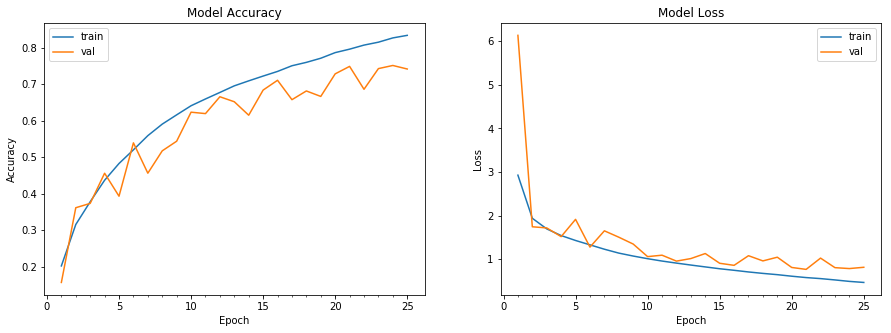

Accuracy on test data is: 74.17


In [22]:
#Compile the model:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Callbacks
checkpointfilepath = "/content/my-drive/My Drive/eva_stored_from_colab/eva_9gradcam_model.hdf5"
checkpoint = ModelCheckpoint(checkpointfilepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]


batch_size = 128
steps_per_epoch = train_features.shape[0] / batch_size

datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, zoom_range=0.0, horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))
#datagen.fit(train_features)

# train the model
start = time.time()
# Train the model
new_model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                 steps_per_epoch = steps_per_epoch, nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks = callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(new_model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Accuracy After cutout

In [24]:
print("BEFORE cutout - Loss: ", "0.7900001672744751", " & Accuracy: ", "0.7478")

checkpointfilepath = "/content/my-drive/My Drive/eva_stored_from_colab/eva_9gradcam_model.hdf5"
model = load_model(checkpointfilepath)

loss, acc = model.evaluate(test_features, test_labels, verbose=0)

print("AFTER cutout - Loss: ", loss, " & Accuracy: ", acc)

BEFORE cutout - Loss:  0.7900001672744751  & Accuracy:  0.7478
AFTER cutout - Loss:  0.7848222110271453  & Accuracy:  0.7514
